In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

![Flags overview image](data/example_images.png)

For the capstone project, you will create your own image dataset from contour plots of a transformed distribution using a random normalising flow network. You will then use the variational autoencoder algorithm to train generative and inference networks, and synthesise new images by interpolating in the latent space.

#### The normalising flow
* To construct the image dataset, you will build a normalising flow to transform the 2-D Gaussian random variable $z=(z_1, z_2)$, which has mean $\mathbf{0}$ and covariance matrix $\Sigma=\sigma^2\mathbf{I}_2$, with $\sigma=0.3$. 
* This normalising flow uses bijectors that are parameterised by the following random variables:
  * $\theta \sim U[0, 2\pi)$
  * $a \sim N(3, 1)$
  
The complete normalising flow is given by the following chain of transformations:
* $f_1(z) = (z_1, z_2 - 2)$,
* $f_2(z) = (z_1, \frac{z_2}{2})$,
* $f_3(z) = (z_1, z_2 + az_1^2)$,
* $f_4(z) = Rz$, where $R$ is a rotation matrix with angle $\theta$,
* $f_5(z) = \tanh(z)$, where the $\tanh$ function is applied elementwise.

The transformed random variable $x$ is given by $x = f_5(f_4(f_3(f_2(f_1(z)))))$. 
* You should use or construct bijectors for each of the transformations $f_i$, $i=1,\ldots, 5$, and use `tfb.Chain` and `tfb.TransformedDistribution` to construct the final transformed distribution. 
* Ensure to implement the `log_det_jacobian` methods for any subclassed bijectors that you write.
* Display a scatter plot of samples from the base distribution.
* Display 4 scatter plot images of the transformed distribution from your random normalising flow, using samples of $\theta$ and $a$. Fix the axes of these 4 plots to the range $[-1, 1]$.

In [3]:
sigma = 0.3

In [4]:
a_dist = tfd.Normal(loc=3., scale=1.)
theta_dist = tfd.Uniform(low=0., high=2*np.pi)

In [5]:
base_dist = tfd.MultivariateNormalDiag(loc=0., scale_diag=[sigma, sigma])

In [6]:
z = base_dist.sample(1000)

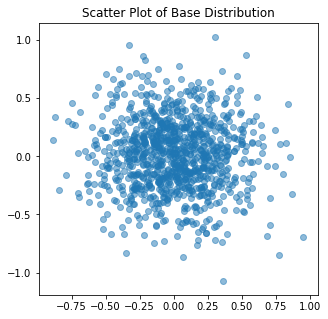

In [7]:
plt.figure(figsize=(5,5))
plt.scatter(z[:,0], z[:,1], alpha=0.5)
plt.title('Scatter Plot of Base Distribution')
plt.show()

In [8]:
class CustomScaleShift(tfb.Bijector):

    def __init__(self, a, name='CustomScaleShift'):
        self.a = tf.cast(a, tf.float32)
        super(CustomScaleShift, self).__init__(
            forward_min_event_ndims=1, 
            is_constant_jacobian=True,
            name=name)

    def _forward(self, z):
        z = tf.cast(z, tf.float32)
        return tf.concat([z[..., 0:1], 
                          z[..., 1:] + self.a* tf.square(z[..., 0:1]) ], axis=-1)
    
    def _inverse(self, y):
        y = tf.cast(y, tf.float32)
        return tf.concat([y[..., 0:1], 
                          y[..., 1:] - self.a * tf.square(y[..., 0:1])], axis=-1)
    
    def _forward_log_det_jacobian(self, z):
        return tf.constant(0., dtype=z.dtype)

In [9]:
class CustomRotation(tfb.Bijector):

    def __init__(self, theta, name='CustomRotation'):
        super(CustomRotation, self).__init__(
            forward_min_event_ndims=1, 
            name=name)
        self.theta = tf.cast(theta, tf.float32)
        self.R = tf.convert_to_tensor([[tf.cos(self.theta), -tf.sin(self.theta)], 
                                       [tf.sin(self.theta), tf.cos(self.theta)]], dtype = tf.float32)
        

    def _forward(self, z):
        z = tf.cast(z, tf.float32)
        return tf.linalg.matvec(self.R, z)
    
    def _inverse(self, y):
        y = tf.cast(y, tf.float32)
        return tf.linalg.matvec(tf.transpose(self.R), y)
        
    def _forward_log_det_jacobian(self, z):
        return tf.constant(0., dtype=z.dtype)

In [10]:
def Transformed(a, theta):
    new_dist = tfd.TransformedDistribution(base_dist, 
                                           bijector = tfb.Chain([tfb.Shift([0., -2.]),
                                                                 tfb.Scale([1., 0.5]),
                                                                 CustomScaleShift(a),
                                                                 CustomRotation(theta),
                                                                 tfb.Tanh()][::-1]))
    return new_dist

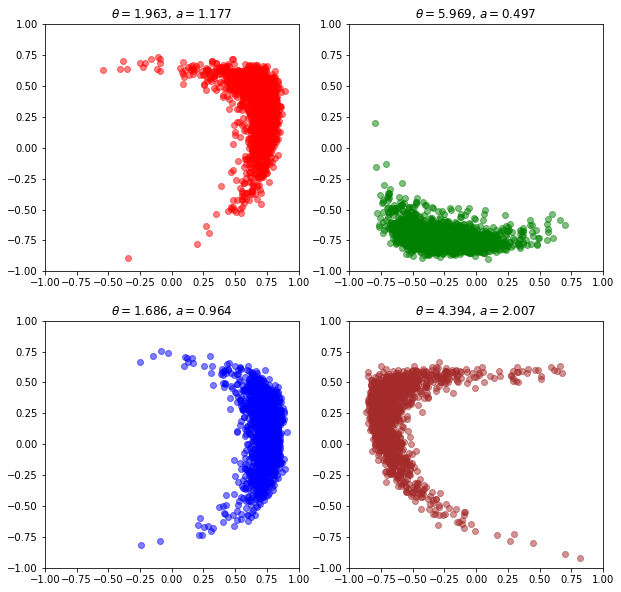

In [11]:
def create_scatter_x():
    theta_ = theta_dist.sample(4)
    a_ = a_dist.sample(4)
    colors_ = ['red', 'green', 'blue', 'brown']
    plt.figure(figsize=(10,10))
    
    for i, (theta, a, c) in enumerate(zip(theta_, a_, colors_)):
        
        flow_dist = Transformed(a, theta)
        
        x = flow_dist.sample(1500)
        plt.subplot(2,2,i+1)
        plt.scatter(x[:,0], x[:,1], alpha=0.5, color=c)
        plt.title("$\\theta={theta:.3f} $, $a={a:.3f} $".format(theta=theta, a=a))
        plt.xlim([-1,1])
        plt.ylim([-1,1])

create_scatter_x()        

## 2. Create the image dataset
* You should now use your random normalising flow to generate an image dataset of contour plots from your random normalising flow network. 
  * Feel free to get creative and experiment with different architectures to produce different sets of images!
* First, display a sample of 4 contour plot images from your normalising flow network using 4 independently sampled sets of parameters. 
  * You may find the following `get_densities` function useful: this calculates density values for a (batched) Distribution for use in a contour plot. 
* Your dataset should consist of at least 1000 images, stored in a numpy array of shape `(N, 36, 36, 3)`.  Each image in the dataset should correspond to a contour plot of a transformed distribution from a normalising flow with an independently sampled set of parameters $s, T, S, b$. It will take a few minutes to create the dataset.
* As well as the `get_densities` function, the `get_image_array_from_density_values` function will help you to generate the dataset. 
  * This function creates a numpy array for an image of the contour plot for a given set of density values Z. Feel free to choose your own options for the contour plots.
* Display a sample of 20 images from your generated dataset in a figure.

In [12]:
# Helper function to compute transformed distribution densities

X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
inputs = np.transpose(np.stack((X, Y)), [1, 2, 0])

def get_densities(transformed_distribution):
    """
    This function takes a (batched) Distribution object as an argument, and returns a numpy 
    array Z of shape (batch_shape, 100, 100) of density values, that can be used to make a 
    contour plot with:
    plt.contourf(X, Y, Z[b, ...], cmap='hot', levels=100)
    where b is an index into the batch shape.
    """
    batch_shape = transformed_distribution.batch_shape
    Z = transformed_distribution.prob(np.expand_dims(inputs, 2))
    Z = np.transpose(Z, list(range(2, 2+len(batch_shape))) + [0, 1])
    return Z

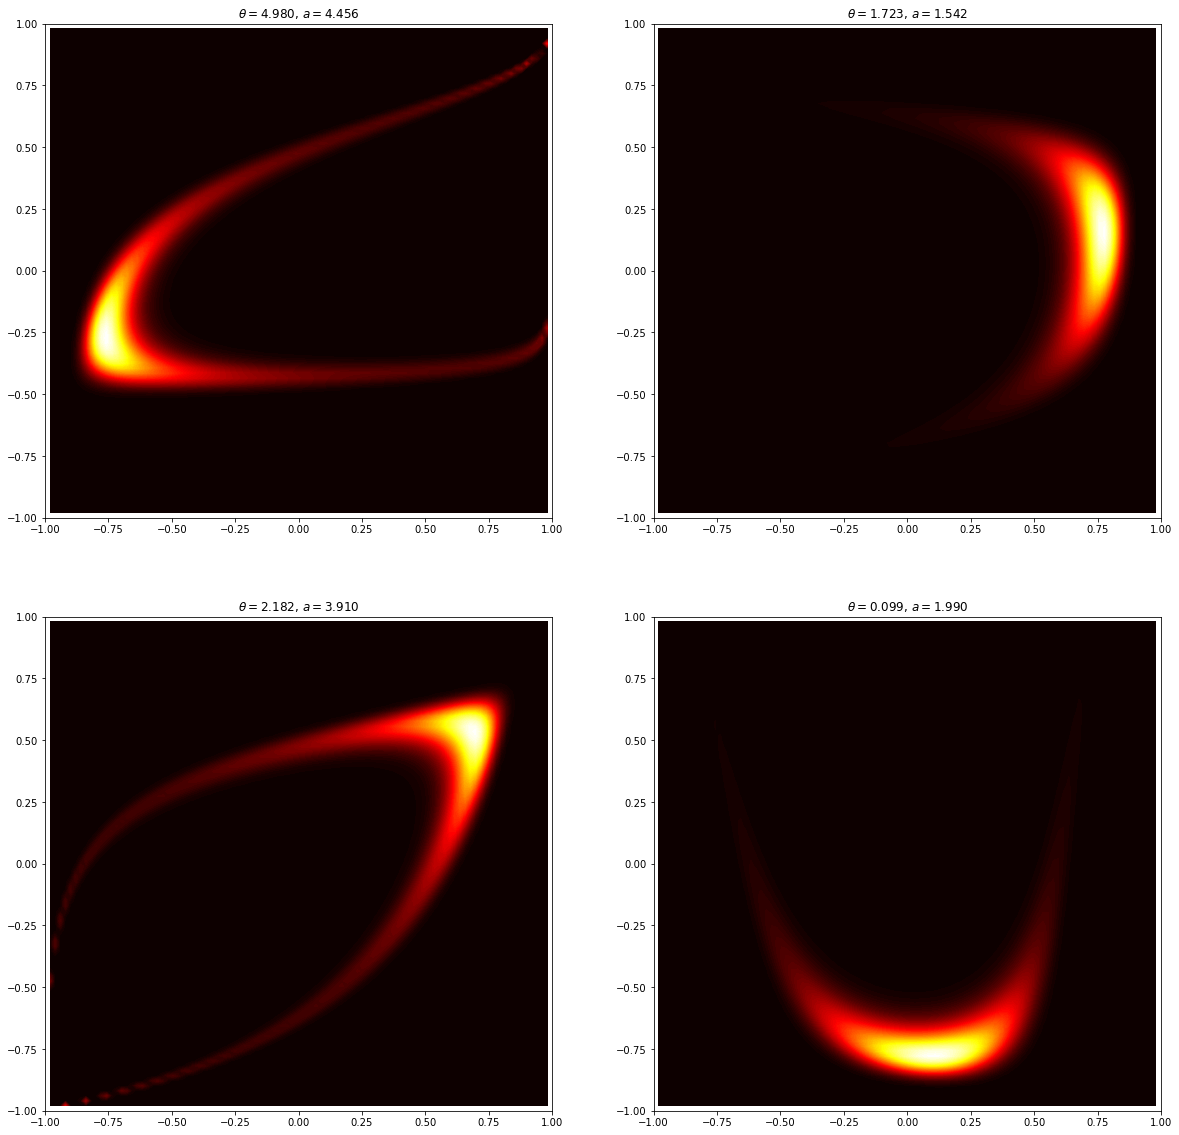

In [13]:
def plot_transformed_contour():
    a_ = a_dist.sample(4)
    theta_ = theta_dist.sample(4)
    plt.figure(figsize=(20, 20))
    for i, (a, theta) in enumerate(zip(a_, theta_)):
        plt.subplot(2, 2, i+1)
        new_dist = Transformed(a, theta)
        batched_new_dist = tfd.BatchReshape(new_dist, [1])
        Z = get_densities(batched_new_dist)
        plt.contourf(X, Y, Z[0, ...], cmap='hot', levels=100)
        plt.title("$\\theta={theta:.3f} $, $a={a:.3f} $".format(theta=theta, a=a))
        
plot_transformed_contour()

In [14]:
# Helper function to convert contour plots to numpy arrays

import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

def get_image_array_from_density_values(Z):
    """
    This function takes a numpy array Z of density values of shape (100, 100)
    and returns an integer numpy array of shape (36, 36, 3) of pixel values for an image.
    """
    assert Z.shape == (100, 100)
    fig = Figure(figsize=(0.67,0.67))
    canvas = FigureCanvas(fig)
    ax = fig.gca()
    ax.contourf(X, Y, Z, cmap='hot', levels=100)
    ax.axis('off')
    #fig.tight_layout(pad=0)

    ax.margins(0)
    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image_from_plot[6:-6,6:-6,:]

In [15]:
N = 2000
imgs = []

for _ in range(N):
    a = a_dist.sample()
    theta = theta_dist.sample()
    new_dist = Transformed(a, theta)
    batched_new_dist = tfd.BatchReshape(new_dist, [1])
    Z = get_densities(batched_new_dist).squeeze()
    imgs.append(get_image_array_from_density_values(Z))
    
x_data = np.array(imgs)

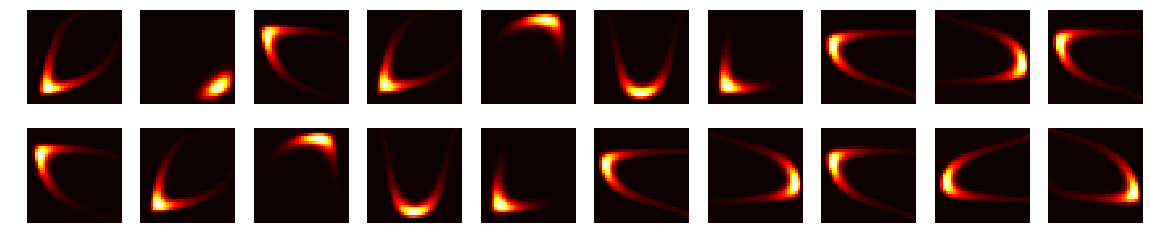

In [16]:
def plot_contour_images():
    
    M = 20
    selected_x = x_data[np.random.choice(np.arange(N), size=M, replace=False)]
    fig, ax = plt.subplots(2, 10, figsize=(20, 4))
    for row in range(2):
        for col in range(10):
            ax[row, col].imshow(selected_x[row*2+col, ...])
            ax[row, col].axis('off')

plot_contour_images()

## 3. Make `tf.data.Dataset` objects
* You should now split your dataset to create `tf.data.Dataset` objects for training and validation data. 
* Using the `map` method, normalise the pixel values so that they lie between 0 and 1.
* These Datasets will be used to train a variational autoencoder (VAE). Use the `map` method to return a tuple of input and output Tensors where the image is duplicated as both input and output.
* Randomly shuffle the training Dataset.
* Batch both datasets with a batch size of 20, setting `drop_remainder=True`.
* Print the `element_spec` property for one of the Dataset objects.

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
x_train, x_val = train_test_split(x_data, test_size=0.2)

In [19]:
x_train = tf.cast(x_train, tf.float32)
x_val = tf.cast(x_val, tf.float32)

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
val_dataset = tf.data.Dataset.from_tensor_slices(x_val)

In [21]:
train_dataset = train_dataset.map(map_func = lambda x: (x/255., x/255.)).shuffle(buffer_size = int(N*0.8)).batch(20, drop_remainder=True)
val_dataset = val_dataset.map(map_func = lambda x: (x/255., x/255.)).batch(20, drop_remainder=True)

In [22]:
print(train_dataset.element_spec)

(TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None), TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None))


## 4. Build the encoder and decoder networks
* You should now create the encoder and decoder for the variational autoencoder algorithm.
* You should design these networks yourself, subject to the following constraints:
   * The encoder and decoder networks should be built using the `Sequential` class.
   * The encoder and decoder networks should use probabilistic layers where necessary to represent distributions.
   * The prior distribution should be a zero-mean, isotropic Gaussian (identity covariance matrix).
   * The encoder network should add the KL divergence loss to the model.
* Print the model summary for the encoder and decoder networks.

In [23]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model

In [24]:
latent_dim = 2
event_shape = (36, 36, 3)

In [25]:
prior = tfd.MultivariateNormalDiag(
    loc = tf.zeros(latent_dim),
    scale_diag = tf.ones(latent_dim))
prior

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

In [26]:
kl_regularizer = tfpl.KLDivergenceRegularizer(
    prior,
    use_exact_kl=False,
    test_points_fn=lambda q: q.sample(5),
    test_points_reduce_axis=0,
    weight=1.5
)


encoder = Sequential([
    Conv2D(16, (3,3), padding='same', strides=(2,2), activation='relu', input_shape=event_shape),
    BatchNormalization(),
    Conv2D(32, (3,3), padding='same', strides=(2,2), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3,3), padding='same', strides=(1,1), activation='relu'),
    BatchNormalization(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
    tfpl.MultivariateNormalTriL(latent_dim,
                               activity_regularizer=kl_regularizer)
])

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [27]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 18, 18, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 18, 18, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 32)          4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 32)          128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 9, 9, 64)          256       
_________________________________________________________________
flatten (Flatten)            (None, 5184)              0

In [28]:
decoder = Sequential([
    Dense(16*9*9, activation='relu', input_shape=(latent_dim,)),
    Reshape(target_shape=(9, 9, 16)),
    Conv2DTranspose(8, (3,3), strides=(2,2), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2DTranspose(3, (3,3), strides=(2,2), padding='same'),
    Flatten(),
    tfpl.IndependentBernoulli(event_shape)
])

decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1296)              3888      
_________________________________________________________________
reshape (Reshape)            (None, 9, 9, 16)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 18, 18, 8)         1160      
_________________________________________________________________
batch_normalization_3 (Batch (None, 18, 18, 8)         32        
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 36, 36, 3)         219       
_________________________________________________________________
flatten_1 (Flatten)          (None, 3888)              0         
_________________________________________________________________
independent_bernoulli (Indep ((None, 36, 36, 3), (None

## 5. Train the variational autoencoder
* You should now train the variational autoencoder. Build the VAE using the `Model` class and the encoder and decoder models. Print the model summary.
* Compile the VAE with the negative log likelihood loss and train with the `fit` method, using the training and validation Datasets.
* Plot the learning curves for loss vs epoch for both training and validation sets.

In [29]:
vae = Model(inputs = encoder.input, outputs = decoder(encoder.output))

In [30]:
vae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 36, 36, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 18, 18, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 18, 18, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 32)          4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 32)          128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 9, 9, 64)          256   

In [31]:
def nll(x, approx_decoding_dist):
    return -tf.reduce_mean(approx_decoding_dist.log_prob(x))

In [32]:
vae.compile(loss=nll, optimizer='Adam')

In [33]:
history = vae.fit(train_dataset, epochs=40, validation_data = val_dataset)

Train for 80 steps, validate for 20 steps
Epoch 1/40
80/80 [==============================] - 19s 238ms/step - loss: 2568.0027 - val_loss: 2314.1785
Epoch 2/40
80/80 [==============================] - 14s 179ms/step - loss: 1927.2694 - val_loss: 1578.4537
Epoch 3/40
80/80 [==============================] - 14s 179ms/step - loss: 1260.1911 - val_loss: 1115.1734
Epoch 4/40
80/80 [==============================] - 14s 175ms/step - loss: 888.8888 - val_loss: 910.5967
Epoch 5/40
80/80 [==============================] - 14s 174ms/step - loss: 706.4648 - val_loss: 785.1041
Epoch 6/40
80/80 [==============================] - 14s 175ms/step - loss: 609.3434 - val_loss: 677.4715
Epoch 7/40
80/80 [==============================] - 14s 175ms/step - loss: 551.7226 - val_loss: 586.6590
Epoch 8/40
80/80 [==============================] - 14s 174ms/step - loss: 515.6471 - val_loss: 520.5767
Epoch 9/40
80/80 [==============================] - 14s 176ms/step - loss: 495.1758 - val_loss: 491.9420
Epoch 1

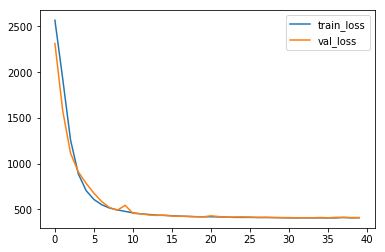

In [34]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

## 6. Use the encoder and decoder networks
* You can now put your encoder and decoder networks into practice!
* Randomly sample 1000 images from the dataset, and pass them through the encoder. Display the embeddings in a scatter plot (project to 2 dimensions if the latent space has dimension higher than two).
* Randomly sample 4 images from the dataset and for each image, display the original and reconstructed image from the VAE in a figure.
  * Use the mean of the output distribution to display the images.
* Randomly sample 6 latent variable realisations from the prior distribution, and display the images in a figure.
  * Again use the mean of the output distribution to display the images.

In [35]:
x_data_normalized = tf.cast(x_data/255., tf.float32)

In [36]:
test_images = x_data_normalized[:1000]
test_images.shape

TensorShape([1000, 36, 36, 3])

In [37]:
encoded_test = encoder(test_images).sample().numpy()

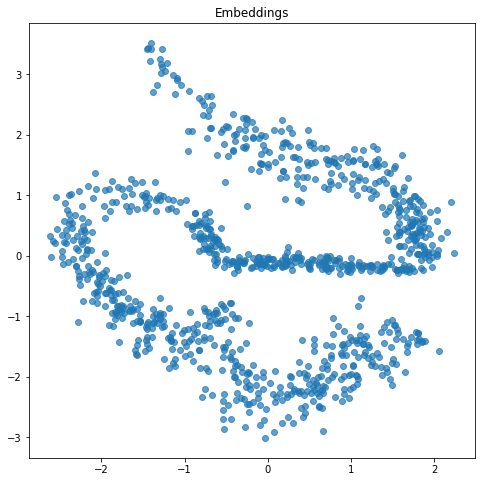

In [38]:
plt.figure(figsize=(8,8))
plt.scatter(encoded_test[:,0], encoded_test[:,1], alpha=0.7)
plt.title('Embeddings')
plt.show()

In [39]:
def reconstruct(image, method = 'sample'):
    return vae(image).sample() if method == 'sample' else vae(image).mean()

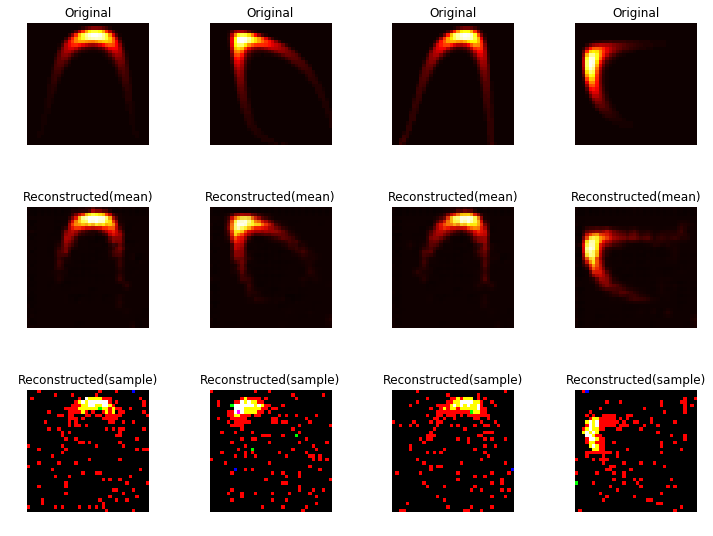

In [40]:
def plot_reconstructed():
    random_images = x_data_normalized[10:14]
    mean_reconstructed = reconstruct(random_images, method='mean')
    sample_reconstructed = reconstruct(random_images, method='sample')
    
    fig, ax = plt.subplots(3,4, figsize=(12, 9))
    plt.title('Reconstructed Images from both mean and sampled from the decoder output')
    for idx, img in enumerate(random_images):
        ax[0][idx].imshow(img)
        ax[0][idx].axis('off')
        ax[0][idx].set_title('Original')
    
    for idx, img in enumerate(mean_reconstructed):
        ax[1][idx].imshow(img)
        ax[1][idx].axis('off')
        ax[1][idx].set_title('Reconstructed(mean)')
        
    for idx, img in enumerate(sample_reconstructed):
        ax[2][idx].imshow(img)
        ax[2][idx].axis('off')
        ax[2][idx].set_title('Reconstructed(sample)')
    
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
plot_reconstructed()

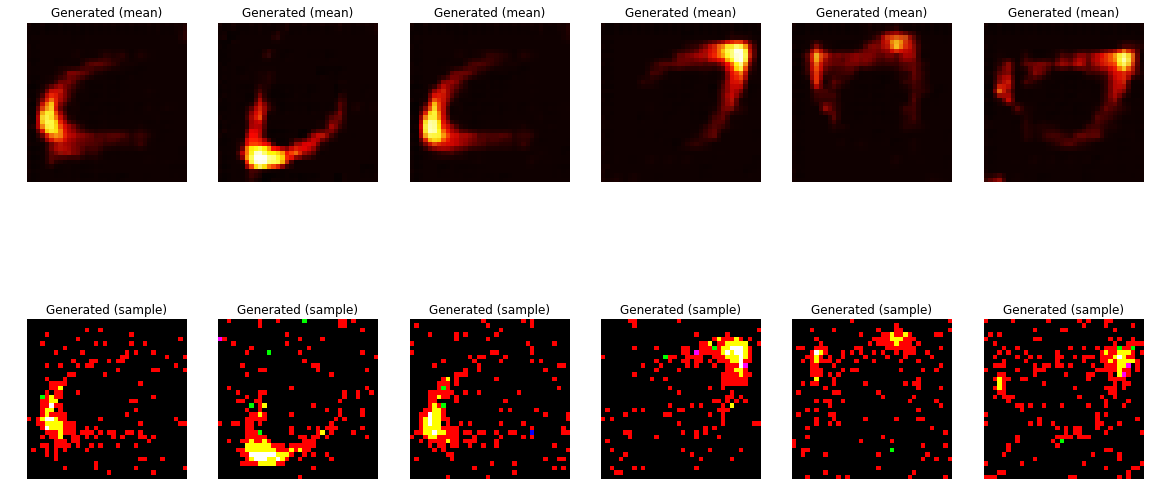

In [41]:
def plot_generated():
    
    random_samples = prior.sample(6)
    mean_reconstructed = decoder(random_samples).mean()
    sample_reconstructed = decoder(random_samples).sample()
    
    fig, ax = plt.subplots(2, 6, figsize=(20, 10))
    plt.title('Generated Images from both mean and sampled from the decoder output')
    for idx, img in enumerate(mean_reconstructed):
        ax[0][idx].imshow(img)
        ax[0][idx].axis('off')
        ax[0][idx].set_title('Generated (mean)')
        
    for idx, img in enumerate(sample_reconstructed):
        ax[1][idx].imshow(img)
        ax[1][idx].axis('off')
        ax[1][idx].set_title('Generated (sample)')
    
    plt.subplots_adjust(wspace=0.2)
    
plot_generated()

## Make a video of latent space interpolation (not assessed)
* Just for fun, you can run the code below to create a video of your decoder's generations, depending on the latent space.

In [42]:
# Function to create animation

import matplotlib.animation as anim
from IPython.display import HTML


def get_animation(latent_size, decoder, interpolation_length=500):
    assert latent_size >= 2, "Latent space must be at least 2-dimensional for plotting"
    fig = plt.figure(figsize=(9, 4))  
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_xlim([-3, 3])
    ax1.set_ylim([-3, 3])
    ax1.set_title("Latent space")
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title("Data space")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)

    # initializing a line variable 
    line, = ax1.plot([], [], marker='o')
    img2 = ax2.imshow(np.zeros((36, 36, 3)))

    freqs = np.random.uniform(low=0.1, high=0.2, size=(latent_size,))
    phases = np.random.randn(latent_size)
    input_points = np.arange(interpolation_length)
    latent_coords = []
    for i in range(latent_size):
        latent_coords.append(2 * np.sin((freqs[i]*input_points + phases[i])).astype(np.float32))

    def animate(i): 
        z = tf.constant([coord[i] for coord in latent_coords])
        img_out = np.squeeze(decoder(z[np.newaxis, ...]).mean().numpy())
        line.set_data(z.numpy()[0], z.numpy()[1])
        img2.set_data(np.clip(img_out, 0, 1))
        return (line, img2)

    return anim.FuncAnimation(fig, animate, frames=interpolation_length, 
                              repeat=False, blit=True, interval=150)

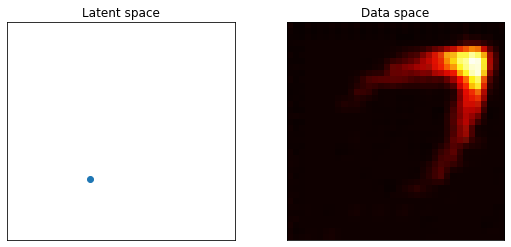

In [43]:
# Create the animation

a = get_animation(latent_dim, decoder, interpolation_length=200)
HTML(a.to_html5_video())